In [1]:
import pandas as pd
import konlpy
import gensim
from pathlib import Path
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

## 0. Load Data

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

# 정규화를 통해 한글만 남기기
train_data['document'] = train_data['document'].str.replace("[^가-힣 ]", "", regex=True)
test_data['document'] = test_data['document'].str.replace("[^가-힣 ]", "", regex=True)

train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])
train_data.head()

,document,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


How do you think about this data?

| id | text | label | 
|---|---|---|
| 10265843 | 너무재밓었다그래서보는것을추천한다 | 0 | 
| 3989148 | 약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요. | 1 |
| 7726829 | 와... | 0 |

## 1. Preprocessing Data

In [3]:
# NaN 결측치 제거
def get_null_index(df):
    null_index = df.loc[df.isnull().sum(1) > 0].index
    print(f'Number of null in data: {len(null_index)}')
    return null_index

print('Train')
train_null_index = get_null_index(train_data)
print('Test')
test_null_index = get_null_index(test_data)

train_data = train_data.drop(index=train_null_index)
test_data = test_data.drop(index=test_null_index)

print()
print(f'Train: {train_data.shape}, Test: {test_data.shape}')

Train
Number of null in data: 5
Test
Number of null in data: 3

Train: (149995, 2), Test: (49997, 2)


In [4]:
# 데이터의 중복 제거
print('Before remove:')
print(f'Train duplicated data: {train_data.duplicated().sum()}')
print(f'Test duplicated data: {test_data.duplicated().sum()}')

train_data = train_data.loc[~train_data.duplicated()].reset_index(drop=True)
test_data = test_data.loc[~test_data.duplicated()].reset_index(drop=True)

print()
print('After remove:')
print(f'Train duplicated data: {train_data.duplicated().sum()}')
print(f'Test duplicated data: {test_data.duplicated().sum()}')


Before remove:
Train duplicated data: 6660
Test duplicated data: 1668

After remove:
Train duplicated data: 0
Test duplicated data: 0


### Introduction to Tokenizer

In [28]:
from konlpy.tag import Mecab

tokenizer = Mecab()
txt = '영화 재밌네요'
# 형태소로 토큰화
print(tokenizer.morphs(txt))

['영화', '재밌', '네요']


### Prepare tokenization

* Mecab
* Sentencepiece(BPE: Byte pair encoding)
* ...

In [7]:
# tokenization
def tokenize(txt):
    stopwords = ['의','가', '이','은','들','는', '과','도','를','으로','에', '한', '하다']
    tokens = tokenizer.morphs(txt)        
    return [t for t in tokens if t not in stopwords]

In [7]:

train_tokens = train_data['document'].apply(tokenize)
test_tokens = test_data['document'].apply(tokenize)

# delete some of data
train_idx_del = train_tokens.loc[train_tokens.apply(len) == 0].index
test_idx_del = test_tokens.loc[test_tokens.apply(len) == 0].index

train_tokens = train_tokens.drop(index=train_idx_del)
test_tokens = test_tokens.drop(index=test_idx_del)

train_labels = train_data.loc[train_tokens.index, 'label'].to_list()
test_labels = test_data.loc[test_tokens.index, 'label'].to_list()

In [8]:
import pickle
with Path('train_tokens.pickle').open('wb') as file:
    pickle.dump((train_tokens.to_list(), train_labels), file)

with Path('test_tokens.pickle').open('wb') as file:
    pickle.dump((test_tokens.to_list(), test_labels), file)

In [9]:
from collections import Counter

LABEL2INDEX = {'negative': 0, 'positive': 1}
INDEX2LABEL = ['negative', 'positive']

# create vocabulary
VOCAB2INDEX = {}
VOCAB2INDEX['[PAD]'] = 0
VOCAB2INDEX['[UNK]'] = 1

unique_tokens = set()  # to get non_duplicate tokens
counter = Counter()
for s in train_tokens:
    unique_tokens.update(set(s))
counter.update(unique_tokens)
print(f'Number of unique tokens: {len(unique_tokens)}')

Number of unique tokens: 47930


In [10]:
for index, token in enumerate(unique_tokens, 2):
    VOCAB2INDEX[token] = index
INDEX2VOCAB = list(VOCAB2INDEX.keys()) 

### Prepare vocab2index

In [6]:
# map to vocab2index
def encode(tokens):
    idx_tokens = []
    for token in tokens:
        if VOCAB2INDEX.get(token) is None:
            idx = VOCAB2INDEX['[UNK]']
        else:
            idx = VOCAB2INDEX[token]
        idx_tokens.append(idx)
    return idx_tokens

def decode(idx_tokens, keep_pad=False):
    tokens = []
    for idx in idx_tokens:
        token = INDEX2VOCAB[idx]
        if not keep_pad and token == '[PAD]':
            continue
        tokens.append(token)
    return ''.join(tokens)

### Train-Validation-Test Split

In [35]:
with Path('train_tokens.pickle').open('rb') as file:
    (train_tokens, train_labels) = pickle.load(file)

with Path('test_tokens.pickle').open('rb') as file:
    (test_tokens, test_labels) = pickle.load(file)
    
train_data = pd.DataFrame(list(zip(*[train_tokens, train_labels])), columns=['document', 'label'])
test_data = pd.DataFrame(zip(*[test_tokens, test_labels]), columns=['document', 'label'])

In [5]:
# select 5% data from train data as validation data

def split_data(train_data, ratio=0.2):
    train_idxes = []
    valid_idxes = []
    for label in range(2):
        index = train_data.loc[train_data['label'] == label].index.to_numpy()
        valid_idx = np.random.choice(index, size=(int(len(index)*ratio),), replace=False)
        train_idx = index[~np.isin(index, valid_idx)]
        train_idxes.append(train_idx)
        valid_idxes.append(valid_idx)

    train_idxes = np.concatenate(train_idxes, axis=0)
    valid_idxes = np.concatenate(valid_idxes, axis=0)
    return train_idxes, valid_idxes

In [36]:
train_idxes, valid_idxes = split_data(train_data, ratio=0.2)
print(f'Train data = {len(train_idxes)}, Valid data = {len(valid_idxes)}')

df_train = train_data.loc[train_idxes].sample(frac=1).reset_index(drop=True)
df_valid = train_data.loc[valid_idxes].sample(frac=1).reset_index(drop=True)
df_test = test_data.reset_index(drop=True)
print(f'Number of train data: {len(df_train)}')
print(f'Number of valid data: {len(df_valid)}')
print(f'Number of test data: {len(df_test)}')

Train data = 114640, Valid data = 28659
Number of train data: 114640
Number of valid data: 28659
Number of test data: 48307


### Prepare Dataloader

In [4]:
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1000

def data_generator(df):
    docs = df['document'].apply(encode).to_list()
    labels = df['label'].to_list()
    for index in range(len(docs)):
        yield docs[index], labels[index]

def get_batches(df, test=False, cache_path=''):
    output_signature = (
        tf.TensorSpec(shape=(None,), dtype=tf.int32),  # names
        tf.TensorSpec(shape=(), dtype=tf.int32)  # labels
    )  # shape, except the batch_size
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(df), 
        output_signature=output_signature
    )
    if not test:
        dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    batches = dataset.cache(cache_path).padded_batch(
        BATCH_SIZE, 
        padded_shapes=(tf.TensorShape([None,]), []), 
        padding_values=(VOCAB2INDEX['[PAD]'], 0)
    )
    return batches

In [ ]:
train_batches = get_batches(df_train, test=False, cache_path='train.loader.plain')
validation_batches = get_batches(df_valid, test=True, cache_path='valid.loader.plain')
test_batches = get_batches(df_test, test=True, cache_path='test.loader.plain')

## 2. Write Model

In [44]:
EPOCHS = 5
vocab_size = len(VOCAB2INDEX)
embedding_size = 200
hidden_size = 512
output_size = len(LABEL2INDEX)
checkpoint_dir = Path('./checkpoints/rnn')

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_size),
    tf.keras.layers.LSTM(units=hidden_size),  # output is hidden states of last time-stamp
    tf.keras.layers.Dense(output_size) 
])
model.summary()

model_name = 'sent'
checkpoint_path = checkpoint_dir / model_name

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weight_only=False
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         9586400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1460224   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 11,047,650
Trainable params: 11,047,650
Non-trainable params: 0
_________________________________________________________________


### Fit model

In [45]:
history = model.fit(
    train_batches, 
    epochs=EPOCHS, 
    validation_data=validation_batches, 
    callbacks=[cp_callback]
)

Epoch 1/5
448/448 [==============================] - 46s 93ms/step - loss: 0.6690 - accuracy: 0.6133 - val_loss: 0.5761 - val_accuracy: 0.7051


INFO:tensorflow:Assets written to: checkpoints/rnn/sent/assets


INFO:tensorflow:Assets written to: checkpoints/rnn/sent/assets


Epoch 2/5
448/448 [==============================] - 26s 57ms/step - loss: 0.4871 - accuracy: 0.7719 - val_loss: 0.4661 - val_accuracy: 0.7856


INFO:tensorflow:Assets written to: checkpoints/rnn/sent/assets


INFO:tensorflow:Assets written to: checkpoints/rnn/sent/assets


Epoch 3/5
448/448 [==============================] - 26s 58ms/step - loss: 0.3658 - accuracy: 0.8426 - val_loss: 0.4601 - val_accuracy: 0.7981


INFO:tensorflow:Assets written to: checkpoints/rnn/sent/assets


INFO:tensorflow:Assets written to: checkpoints/rnn/sent/assets


Epoch 4/5
448/448 [==============================] - 26s 58ms/step - loss: 0.3205 - accuracy: 0.8682 - val_loss: 0.4677 - val_accuracy: 0.8017


INFO:tensorflow:Assets written to: checkpoints/rnn/sent/assets


INFO:tensorflow:Assets written to: checkpoints/rnn/sent/assets


Epoch 5/5
448/448 [==============================] - 26s 58ms/step - loss: 0.2802 - accuracy: 0.8868 - val_loss: 0.4796 - val_accuracy: 0.8063


INFO:tensorflow:Assets written to: checkpoints/rnn/sent/assets


INFO:tensorflow:Assets written to: checkpoints/rnn/sent/assets


## 3. Evaluate Model

In [3]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(EPOCHS)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axes
    ax1.plot(epochs_range, acc, label='Training Accuracy')
    ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')

    ax2.plot(epochs_range, loss, label='Training Loss')
    ax2.plot(epochs_range, val_loss, label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    plt.tight_layout()
    plt.legend()
    plt.show()

10/10 [==============================] - 1s 55ms/step - loss: 0.4555 - accuracy: 0.8266
Test Loss: 0.4555, Accuracy: 0.8266


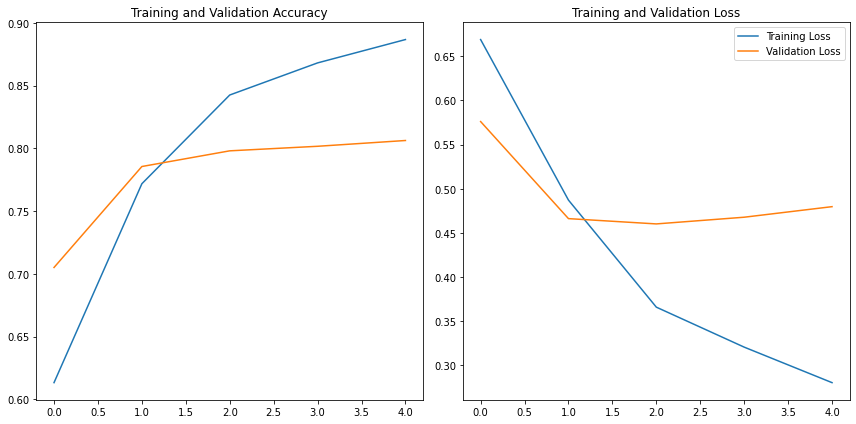

In [46]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_size),
    tf.keras.layers.LSTM(units=hidden_size),  # output is hidden states of last time-stamp
    tf.keras.layers.Dense(output_size) 
])
new_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

new_model.load_weights(checkpoint_path)

loss, accuracy = new_model.evaluate(test_batches, steps=10)
print(f'Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

plot_results(history)

### Try by ourself

In [8]:
def predict(model, txt):
    tokens = tokenizer.morphs(txt)
    idx_tokens = encode(tokens)
    pred = model.predict(np.array([idx_tokens]))
    return INDEX2LABEL[pred.argmax()]

In [47]:
name = input('Please Insert Comment in Korean: ')
pred = predict(model, name)
print(f'Your Name = {name}, Prediction = {pred}')

Please Insert Comment in Korean: 영화 참 잘 만들었네
Your Name = 영화 참 잘 만들었네, Prediction = positive


## 4. Load Word2Vec as Pretrained Embedding


```
!pip install gdown
!gdown https://drive.google.com/uc?id=101KTuugRt_iTaN_JANsCxcEx_4aSlOVJ
```

In [22]:
!pip install gdown
!gdown https://drive.google.com/uc?id=101KTuugRt_iTaN_JANsCxcEx_4aSlOVJ

Downloading...
From: https://drive.google.com/uc?id=101KTuugRt_iTaN_JANsCxcEx_4aSlOVJ
To: /aiffel/aiffel2022/ko.model
100%|██████████████████████████████████████| 68.1M/68.1M [00:01<00:00, 61.5MB/s]


In [9]:
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = gensim.models.KeyedVectors.load_word2vec_format('ko.model')

In [10]:
print(f'Class of `word_vectors.vectors` = {type(word_vectors.vectors)}')
print(f'(Vocab Size, Embedding Size) = {word_vectors.vectors.shape}')
print(f'Class of `word_vectors.index_to_key` = {type(word_vectors.index_to_key)}')
print(word_vectors.index_to_key[500:510])

Class of `word_vectors.vectors` = <class 'numpy.ndarray'>
(Vocab Size, Embedding Size) = (30185, 200)
Class of `word_vectors.index_to_key` = <class 'list'>
['지구', '연결', '시기', '국민', '이탈리아', '므로', '진행', '한편', '주기', '생산']


In [11]:
# indexing in word2vec object
a = word_vectors[500]
b = word_vectors['지구']

print('index=500(지구)', a[:5])
print('index=500(지구)', b[:5])

index=500(지구) [-0.38355422  0.48232487 -2.477071    1.3113756  -2.0463424 ]
index=500(지구) [-0.38355422  0.48232487 -2.477071    1.3113756  -2.0463424 ]


In [12]:
# get similar words
word_vectors.most_similar('이탈리아')

[('스페인', 0.7812455296516418),
 ('프랑스', 0.7344648838043213),
 ('나폴리', 0.7137762308120728),
 ('네덜란드', 0.6884961128234863),
 ('밀라노', 0.6815128922462463),
 ('피렌체', 0.671885073184967),
 ('스웨덴', 0.6689110398292542),
 ('벨기에', 0.6632754802703857),
 ('헝가리', 0.662670373916626),
 ('제노바', 0.6600825786590576)]

In [13]:
# redefine vocab
LABEL2INDEX = {'negative': 0, 'positive': 1}
INDEX2LABEL = ['negative', 'positive']

EPOCHS = 5
embedding_size = word_vectors.vector_size
hidden_size = 512
output_size = len(LABEL2INDEX)
checkpoint_dir = Path('./checkpoints/rnn')

print(f'first index word in word_vectors is {word_vectors.index_to_key[0]}')
# need to add other index

INDEX2VOCAB = ['[PAD]', '[UNK]'] + word_vectors.index_to_key
VOCAB2INDEX = {v: i for i, v in enumerate(INDEX2VOCAB)}
vocab_size = len(VOCAB2INDEX)

# modify word_vectors
wv = word_vectors.vectors
modified_wv = np.vstack([np.zeros((1, embedding_size)), np.random.randn(1, embedding_size), wv])
print(f'After modified, the shape is = {modified_wv.shape}, vocab size is = {len(INDEX2VOCAB)}')

first index word in word_vectors is 하
After modified, the shape is = (30187, 200), vocab size is = 30187


In [65]:
from tqdm.notebook import tqdm

# need to change tokenizer
def remove_unused(tokens):
    new_tokens = []
    for tkn in tokens:
        if tkn in INDEX2VOCAB:
            new_tokens.append(tkn)
    return new_tokens
    
def get_new_tokens_labels(old_tokens, old_labels):
    new_tokens = []
    new_labels = []
    for i, tokens in tqdm(enumerate(old_tokens), total=len(old_tokens)):
        new_tkns = remove_unused(tokens)
        if len(new_tkns) > 0:
            new_tokens.append(new_tkns)
            new_labels.append(old_labels[i])
    return new_tokens, new_labels

with Path('train_tokens.pickle').open('rb') as file:
    (train_tokens, train_labels) = pickle.load(file)

with Path('test_tokens.pickle').open('rb') as file:
    (test_tokens, test_labels) = pickle.load(file)

    
new_train_tokens, new_train_labels = get_new_tokens_labels(train_tokens, train_labels)
new_test_tokens, new_test_labels = get_new_tokens_labels(test_tokens, test_labels)

with Path('new_train_tokens.pickle').open('wb') as file:
    pickle.dump((new_train_tokens, new_train_labels), file)

with Path('new_test_tokens.pickle').open('wb') as file:
    pickle.dump((new_test_tokens, new_test_labels), file)

  0%|          | 0/143299 [00:00<?, ?it/s]

  0%|          | 0/48307 [00:00<?, ?it/s]

In [14]:
with Path('new_train_tokens.pickle').open('rb') as file:
    (train_tokens, train_labels) = pickle.load(file)

with Path('new_test_tokens.pickle').open('rb') as file:
    (test_tokens, test_labels) = pickle.load(file)

train_data = pd.DataFrame(list(zip(*[train_tokens, train_labels])), columns=['document', 'label'])
test_data = pd.DataFrame(zip(*[test_tokens, test_labels]), columns=['document', 'label'])

train_idxes, valid_idxes = split_data(train_data, ratio=0.2)
print(f'Train data = {len(train_idxes)}, Valid data = {len(valid_idxes)}')

df_train = train_data.loc[train_idxes].sample(frac=1).reset_index(drop=True)
df_valid = train_data.loc[valid_idxes].sample(frac=1).reset_index(drop=True)
df_test = test_data.reset_index(drop=True)
print(f'Number of train data: {len(df_train)}')
print(f'Number of valid data: {len(df_valid)}')
print(f'Number of test data: {len(df_test)}')

Train data = 113930, Valid data = 28482
Number of train data: 113930
Number of valid data: 28482
Number of test data: 47973


In [15]:
train_batches = get_batches(df_train, test=False, cache_path='train.loader.wv')
validation_batches = get_batches(df_valid, test=True, cache_path='valid.loader.wv')
test_batches = get_batches(df_test, test=True, cache_path='test.loader.wv')

### apply word vectors into embedding layer

In [16]:
def initializer(shape, dtype=None):
    return modified_wv

embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_size, embeddings_initializer=initializer)

In [17]:
x = np.array([[502]])  # token idx for 지구
e = embedding_layer(x)
print(e[0, 0, :5])

tf.Tensor([-0.38355422  0.48232487 -2.477071    1.3113756  -2.0463424 ], shape=(5,), dtype=float32)


In [23]:
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.LSTM(units=hidden_size),  # output is hidden states of last time-stamp
    tf.keras.layers.Dense(output_size) 
])
model.summary()

model_name = 'sent_wv'
checkpoint_path = checkpoint_dir / model_name

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weight_only=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         6037400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1460224   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 7,498,650
Trainable params: 7,498,650
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(
    train_batches, 
    epochs=EPOCHS, 
    validation_data=validation_batches, 
    callbacks=[cp_callback]
)

Epoch 1/5
446/446 [==============================] - 24s 52ms/step - loss: 0.6442 - accuracy: 0.5843 - val_loss: 0.4669 - val_accuracy: 0.7910
INFO:tensorflow:Assets written to: checkpoints/rnn/sent_wv/assets


INFO:tensorflow:Assets written to: checkpoints/rnn/sent_wv/assets


Epoch 2/5
446/446 [==============================] - 23s 52ms/step - loss: 0.3865 - accuracy: 0.8312 - val_loss: 0.4210 - val_accuracy: 0.8166
INFO:tensorflow:Assets written to: checkpoints/rnn/sent_wv/assets


INFO:tensorflow:Assets written to: checkpoints/rnn/sent_wv/assets


Epoch 3/5
446/446 [==============================] - 23s 52ms/step - loss: 0.3460 - accuracy: 0.8510 - val_loss: 0.4324 - val_accuracy: 0.8184
INFO:tensorflow:Assets written to: checkpoints/rnn/sent_wv/assets


INFO:tensorflow:Assets written to: checkpoints/rnn/sent_wv/assets


Epoch 4/5
446/446 [==============================] - 23s 52ms/step - loss: 0.3298 - accuracy: 0.8596 - val_loss: 0.4286 - val_accuracy: 0.8176
Epoch 5/5
446/446 [==============================] - 23s 52ms/step - loss: 0.3201 - accuracy: 0.8638 - val_loss: 0.4235 - val_accuracy: 0.8186
INFO:tensorflow:Assets written to: checkpoints/rnn/sent_wv/assets


INFO:tensorflow:Assets written to: checkpoints/rnn/sent_wv/assets


10/10 [==============================] - 1s 53ms/step - loss: 0.4159 - accuracy: 0.8262
Test Loss: 0.4159, Accuracy: 0.8262


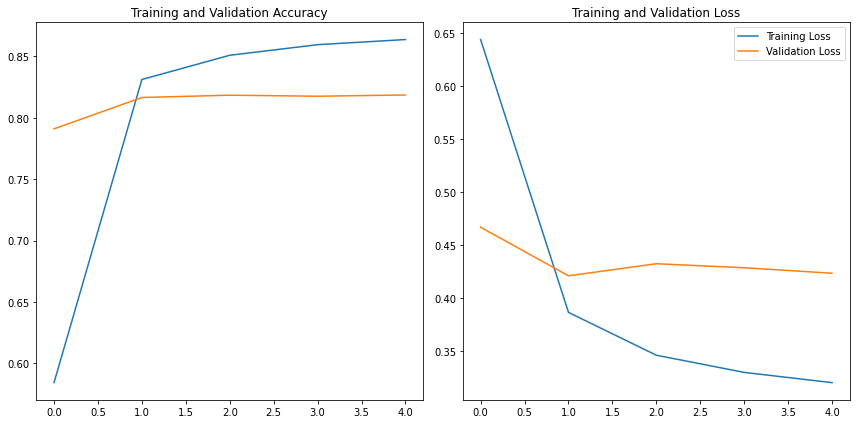

In [26]:
new_model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.LSTM(units=hidden_size),  # output is hidden states of last time-stamp
    tf.keras.layers.Dense(output_size) 
])
new_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
new_model.load_weights(checkpoint_path)

loss, accuracy = new_model.evaluate(test_batches, steps=10)
print(f'Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

plot_results(history)

In [32]:
def new_tokenizer(txt):
    tokens = tokenizer.morphs(txt)
    new_tokens = []
    for tkn in tokens:
        if tkn in INDEX2VOCAB:
            new_tokens.append(tkn)
    return new_tokens

def predict2(model, txt):
    tokens = new_tokenizer(txt)
    print(tokens)
    idx_tokens = encode(tokens)
    pred = model.predict(np.array([idx_tokens]))
    return INDEX2LABEL[pred.argmax()]

In [33]:
name = input('Please Insert Comment in Korean: ')
pred = predict2(model, name)
print(f'Your Name = {name}, Prediction = {pred}')

Please Insert Comment in Korean: 아니 진짜 이게 맞아?
['아니', '진짜', '맞', '아', '?']
Your Name = 아니 진짜 이게 맞아?, Prediction = negative
